# 0) Required modules
If you do not have the required modules installed you can uncomment and run the following cell. The notebook is going to heavily rely on healpy, numpy and PySM

In [ ]:
# !pip install healpy --user
# !pip install pysm3 --user

In [1]:
import sys
sys.path.append("~/.local/lib/python3.6/site-packages")
import healpy as hp
import numpy as np
import pylab as pl
import pysm

# Reproduce Planck colormap
from matplotlib.colors import ListedColormap
colombi1_cmap = ListedColormap(np.loadtxt("https://raw.githubusercontent.com/zonca/paperplots/master/data/Planck_Parchment_RGB.txt")/255.)
colombi1_cmap.set_bad("gray") # color of missing pixels
colombi1_cmap.set_under("white") # color of background, necessary if you want to use
cmap = colombi1_cmap

%matplotlib inline

# 1) Data
We will start with loading the dust intensity map obtained with the Planck COMMANDER pipeline. More details on how this is obtained can be found [here](https://arxiv.org/abs/1807.06208). The fits file consists of multiple columns. The description of the first seven columns reads
```
TTYPE1  = 'I_ML_FULL '  / Full period Intensity map                      
TTYPE2  = 'I_ML_HM1 '   / Half Mission 1 Intensity map                   
TTYPE3  = 'I_ML_HM2 '   / Half Mission 2 Intensity map                   
TTYPE4  = 'I_ML_HR1 '   / Half Ring 1 Intensity map                      
TTYPE5  = 'I_ML_HR2 '   / Half Ring 2 Intensity map                      
TTYPE6  = 'I_ML_YR1 '   / Year 1 Intensity map                           
TTYPE7  = 'I_ML_YR2 '   / Year 2 Intensity map 
```
For now we will only care about the first column, which contains the map of the full dataset. The maps are given in $\mu K_{RJ}$ units. We will work in $\mu K_{CMB}$ units in the following, therefore we have to convert the units first. More details on what these units mean are [here](https://github.com/bthorne93/PySM_public/blob/master/docs/unit_conversion.pdf). In order to keep memory usage low we will downgrade the resolution of the map to a [HEALPix resolution parameter](https://healpix.jpl.nasa.gov/pdf/intro.pdf) of $N_{side}=256$.

In [31]:
dust_map=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/COM_CompMap_ThermalDust-commander_2048_R2.00.fits',0)

cst = 56.8
nu = 545. # The reference frequency in GHz
CMBtoRJ=(nu/cst)**2*np.exp(nu/cst)/(np.exp(nu/cst)-1)**2

dust_map*=1./CMBtoRJ

nside=512

dust_map=hp.ud_grade(dust_map,nside)

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


Next we will compare it visually to the Planck HFI 353 GHz map. We see that the structure looks similar, but the absolute values values seem off. This is because thermal dust emission is brighter at 545 GHz (the reference frequency the COMMANDER dust map is given in) than 353 GHz. The brightness of dust follows a so called modified black-body spectrum, which you can see in the red band in the image below (along with several other foreground components, find more [here](https://arxiv.org/pdf/1502.01588.pdf)). 
<img src="https://www.cosmos.esa.int/documents/387566/425793/2015_FGSpectra/310c443d-9c44-433e-843a-61363a62f9da?t=1423091990056" width="500" />
We will deal with this frequency scaling later on in the notebook. You can also see small anisotropies appearing where the Galaxy is less bright, which are not present in the dust map. This is the CMB.

You can also go ahead and try to compare the Q and U maps at 353 GHz with the dust intensity.

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


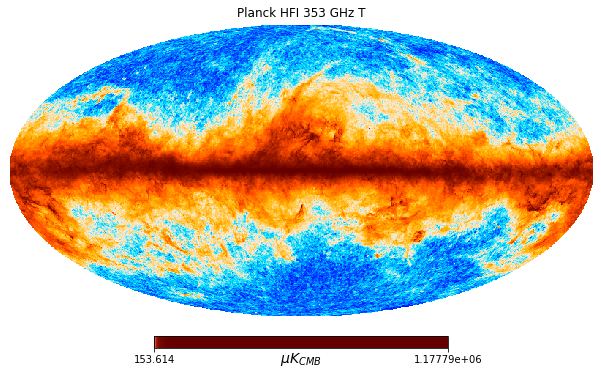

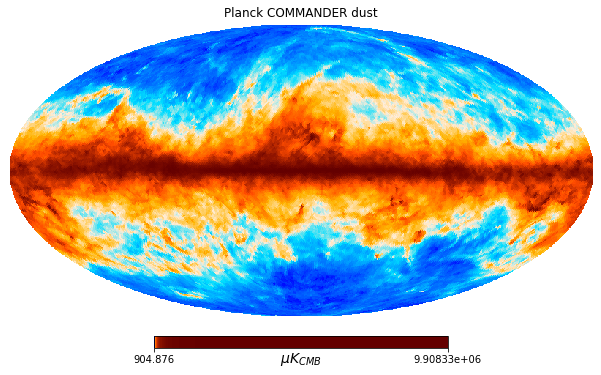

In [3]:
freq_map=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/353/HFI_SkyMap_353_2048_R3.01_full.fits',0)
freq_map=hp.ud_grade(freq_map,256)
freq_map*=1e6 # These maps are given in K_{CMB}
hp.mollview(freq_map,title='Planck HFI 353 GHz T', cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist')

hp.mollview(dust_map,title='Planck COMMANDER dust', cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist')

To get a rough idea how foreground cleaning works we assume a simple sky model containing the CMB intensity, which is frequency independent, and some intensity of dust depending on the frequency, $\nu$, described by a scalar function $A^\nu$,
$$ I^\nu=I^{CMB}+A^\nu \cdot I^{dust}.$$
Also let's assume that dust is dominating at 353 GHz (which may be true for polarization, but a very crude assumption for intensity)
$$I^{dust}=I^{353\ GHz}.$$
We could then try to get a clean CMB by subtracting out the template
$$I^{CMB}=I^{100\ GHz}-A^{100\ GHz} \cdot I^{dust}$$
once we obtain an estimate of $A^{100\ GHz}$ by a least square minimization of the right hand side of the equation. We will revisit and compare the value we obtain for $A^{100\ GHz}$ later.

In [ ]:
from scipy.optimize import lsq_linear

dust_map=freq_map

freq_map_100=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/100/HFI_SkyMap_100_2048_R3.01_full.fits',0)
freq_map_100=hp.ud_grade(freq_map_100,256)
freq_map_100*=1e6 # These maps are given in K_{CMB}

res=lsq_linear(dust_map[:,np.newaxis],freq_map_100)

cmb_map=freq_map_100-res.x[0]*dust_map
print('The estimate for A^{100 GHz}: %.03f'%res.x[0])

hp.mollview(freq_map_100,title='Planck HFI 100 GHz uncleaned', cmap=cmap, unit=r'$\mu K_{CMB}$',min=-200,max=200)
hp.mollview(cmb_map,title='Planck HFI 100 GHz cleaned', cmap=cmap, unit=r'$\mu K_{CMB}$',min=-200,max=200)

# 2) Dust model
To model the polarized galactic emission we start from the integral equations for the emission of an optically thin medium [[Planck 2015](https://www.aanda.org/articles/aa/pdf/2015/04/aa24086-14.pdf)]
$$ I(\nu)=\int S(\nu) \left[ 1-p_0\left( \cos^2\gamma -\frac{2}{3} \right) \right] d\tau_\nu $$
$$ Q(\nu)=\int p_0 S(\nu) \cos(2\phi) \cos^2\gamma d\tau_\nu $$
$$ U(\nu)=\int p_0 S(\nu) \sin(2\phi) \cos^2\gamma d\tau_\nu, $$
where $S(\nu)$ is the so-called source function, $\tau_\nu$ is the optical depth, $p_0$ is a parameter describing the dust polarization properties and $\gamma$ and $\phi$ describe the orientation of the galactic magnetic field with respect of the plane of the sky. Those integrals can essentially be seen as integrals along the line-of-sight.

First let's follow [Planck 2016](https://arxiv.org/abs/1604.01029) Eq. 5 and compute the two basis vectors 
$\mathbf{n}$ and $\mathbf{e}$ for each HEALPix pixel, resulting in two $3\times N_{pix}$ arrays.

In [32]:
npix=hp.nside2npix(nside)
r=hp.pix2vec(nside,np.arange(npix))

#North vector n=(rxz)xz (z=[0,0,1]) 
n=r*r[2]*(-1.)
n[2]+=1.
n=n/np.sqrt(np.einsum('sp,sp->p',n,n))

#East vector e=-rxn
e=np.cross(r,n,axisa=0,axisb=0).T*(-1.)
e=e/np.sqrt(np.einsum('sp,sp->p',e,e))

Next we define a function to project a three-dimonsional vector field, $\mathbf{B}$, a $3\times N_{pix}$ array, onto the sphere described by the two angles $\gamma$ and $\phi$ that we introduced earlier (Eq. 6 in [Planck 2016](https://arxiv.org/abs/1604.01029)).

In [33]:
def do_projection(B,Bdims='sp'):
    B=B/np.sqrt(np.einsum('%s,%s->p'%(Bdims,Bdims),B,B))
    Bperp=B-r*np.einsum('%s,sp->p'%Bdims,B,r)
    phi=np.pi-np.sign(np.einsum('sp,sp->p',Bperp,e))*np.arccos(np.einsum('sp,sp->p',Bperp,n)/np.sqrt(np.einsum('sp,sp->p',Bperp,Bperp)))
    cos2gamma=1.-np.abs(np.einsum('%s,sp->p'%Bdims,B,r))**2
    return phi,cos2gamma

Now we can introduce a function, which simulates a galactic magnetic field and projects it onto the two-dimensional sky sphere. A common decomposition of the magnetic field is 
$$\mathbf{B}=\mathbf{B}_0+\mathbf{B}_t,$$
where $\mathbf{B}_0$ is the "mean" components and $\mathbf{B}_t$ is a turbulent component. Far away from the galactic disk, the region of the sky we will observe for CMB measurements, we can assume $\mathbf{B}_0$ to have a fixed orientation. This orientation is described by the  Galactic longitude and latitude $l_0$ and $b_0$. The turbulent component is modeled as $|\mathbf{B}_0|f_M \hat{\mathbf{B}}_t$. The turbulent field orientation is simulated as by drawing each component of the 3D vector at each in each direction on the sky from a correlated Gaussian, with variance 
$$C_\ell \sim \ell^{\alpha_M}.$$

In [34]:
lmax=3*nside-1
ell=np.arange(lmax+1)

def simulate_GMF(l0,b0,p0,alphaM,fM,N):
    N=int(N)

    B0=np.array([np.cos(l0)*np.cos(b0),np.sin(l0)*np.cos(b0),np.sin(b0)])
    
    phi=np.zeros((N,npix))
    cos2gamma=np.zeros((N,npix))
    
    Cell=ell**alphaM
    Cell[:2]=0.
    
    for i in range(N):
        while True:
            Bt=np.array([hp.synfast(Cell,nside,verbose=False),hp.synfast(Cell,nside,verbose=False),hp.synfast(Cell,nside,verbose=False)])
            Bt=Bt/np.sqrt(np.einsum('sp,sp->p',Bt,Bt))
            B=B0[:,np.newaxis]+fM*Bt
            phi[i],cos2gamma[i]=do_projection(B)
            if (np.sum(np.isnan(phi[i]))+np.sum(np.isnan(cos2gamma[i])))==0: break
                
    return cos2gamma,phi

Following [Vansyngel et al. 2016](https://arxiv.org/pdf/1611.02577.pdf) we will discretize this integral in $N$ "layers", such that
$$ I(\nu)=\sum_i^N S_i(\nu) \left[ 1-p_0\left( \cos^2 \gamma_i -\frac{2}{3}\right) \right]$$
$$ Q(\nu)=\sum_i^N S_i(\nu) p_0 \cos(2\phi_i) \cos^2 \gamma_i$$
$$ U(\nu)=\sum_i^N S_i(\nu) p_0 \sin(2\phi_i) \cos^2 \gamma_i.$$
For now, we will assume the same source function in each layer, $S_i(\nu)=S(\nu)$, and will factor out the frequency dependence into pre-factors, $A_\nu$, which we will treat later on, resulting in
$$ I(\nu)=A_\nu \cdot S \sum_i^N \left[ 1-p_0\left( \cos^2 \gamma_i -\frac{2}{3}\right) \right]$$
$$ Q(\nu)=A_\nu \cdot S \sum_i^N p_0 \cos(2\phi_i) \cos^2 \gamma_i$$
$$ U(\nu)=A_\nu \cdot S \sum_i^N p_0 \sin(2\phi_i) \cos^2 \gamma_i.$$
Defining $A_\nu=1$ for our reference frequency $\nu=545$ GHz allows us to compute $S$ given a dust intensity map, $I(\nu)$, and a galactic magnetic field, $(\gamma,\phi)$.

In [35]:
def make_dustsim(l0,b0,p0,alphaM,fM,N):
    dust_sim=np.zeros((3,npix))
    
    cos2gamma,phi=simulate_GMF(l0,b0,p0,alphaM,fM,N)
    
    S=dust_map/np.sum(1.-(cos2gamma-2./3.)*p0,axis=0)
    
    dust_sim[0]=dust_map
    dust_sim[1]=S*p0*np.sum(np.cos(2.*phi)*cos2gamma,axis=0)
    dust_sim[2]=S*p0*np.sum(np.sin(2.*phi)*cos2gamma,axis=0)
    
    return dust_sim

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


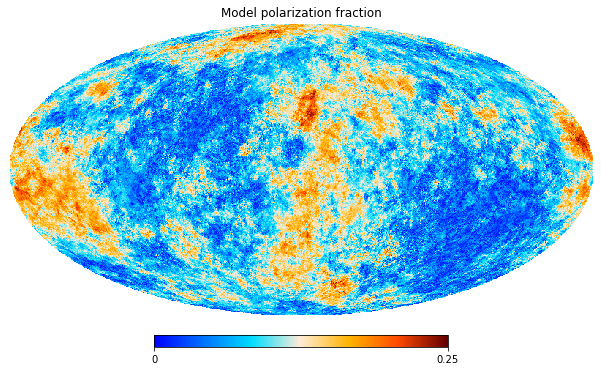

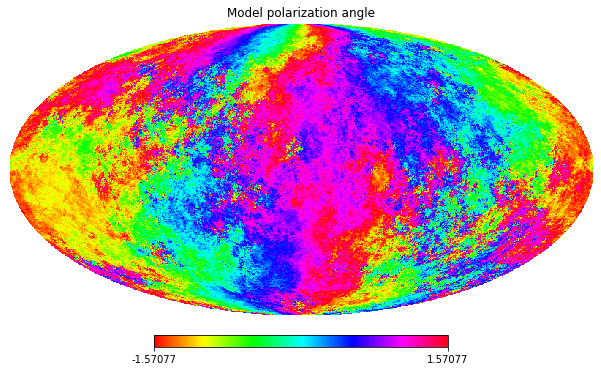

In [36]:
d2r=np.pi/180.

dust_sim=make_dustsim(l0=70*d2r,\
                      b0=24*d2r,\
                      p0=0.26,\
                      alphaM=-2.5,\
                      fM=0.9,\
                      N=7)

# hp.mollview(dust_sim[1],title='Planck model dust Q', cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist')
# hp.mollview(dust_sim[2],title='Planck model dust U', cmap=cmap, unit=r'$\mu K_{CMB}$', norm='hist')
hp.mollview(np.sqrt((dust_sim[1]**2+dust_sim[2]**2)/dust_sim[0]**2),min=0,max=.25,title='Model polarization fraction', cmap=cmap)
hp.mollview(.5*np.arctan2(-dust_sim[2],dust_sim[1]),title='Model polarization angle', cmap=pl.cm.hsv)

# 3) Model comparisons with real data
Let's compare our model to the real observation of polarized dust emission with the Planck 353 GHz maps. The model is only valid for regions far away from the Galactic plane, hence we will focus only on the observation region of SPT-3G and BICEP Array. To do so we load the SPT-3G mask and rotate the model as well as the Planck 353 GHz map from Galactic into Celestial coordinates.

In [5]:
nside=256

freq_maps=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/353/HFI_SkyMap_353_2048_R3.01_full.fits',[0,1,2])
freq_maps=hp.ud_grade(freq_maps,nside)
freq_maps*=1e6 # These maps are given in K_{CMB}

rot = hp.Rotator(coord=['G','C'])
freq_maps=rot.rotate_map_pixel(freq_maps)


mask=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_smallfield_cel_n0512.fits')
mask=np.nan_to_num(hp.ud_grade(mask,nside))
mask[mask<0]=0

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


First we compare the distribution of polarization fractions per pixel within the SPT-3G patch and try to match them by tuning the model's parameters.

In [9]:
d2r=np.pi/180.

dust_sim=make_dustsim(l0=70*d2r,\
                      b0=24*d2r,\
                      p0=0.15,\
                      alphaM=-2.5,\
                      fM=3.,\
                      N=4)
dust_sim=rot.rotate_map_pixel(dust_sim)

pl.hist((np.sqrt((dust_sim[1]**2+dust_sim[2]**2)/dust_sim[0]**2))[mask!=0],bins=np.linspace(0,.25,10),histtype='step',label='simulation')
pl.hist((np.sqrt((freq_maps[1]**2+freq_maps[2]**2)/freq_maps[0]**2))[mask!=0],bins=np.linspace(0,.25,10),histtype='step',label='real data')
pl.legend()

pl.ylabel('count')
pl.xlabel('polarization fraction')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


NameError: name 'rot' is not defined

Next have a look at the resulting maps of the polarization fraction. Note that the model attempts to reproduce the "statistical properties" of this map, not the exact patterns. hence the distribution in form of the histogram above is the better way to compare the two.

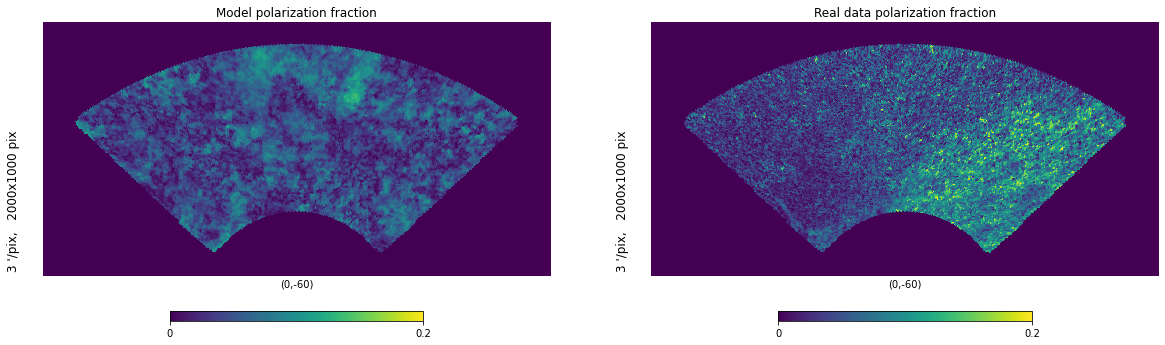

In [12]:
pl.figure(figsize=(20,8))
pl.subplot('121')
hp.gnomview(mask*np.sqrt((dust_sim[1]**2+dust_sim[2]**2)/dust_sim[0]**2),rot=[0,-60],xsize=2000,ysize=1000,reso=3,max=.2,hold=True,title='Model polarization fraction',sub='121')
pl.subplot('122')
hp.gnomview(mask*np.sqrt((freq_maps[1]**2+freq_maps[2]**2)/freq_maps[0]**2),rot=[0,-60],xsize=2000,ysize=1000,reso=3,max=.2,hold=True,title='Real data polarization fraction',sub='122')

Before we can compare intensity and polarization Q/U maps we have to remember that the reference frequency for out model has $\nu=545\ GHz$, while we only have polarization maps from Planck up to $353\ GHz$. We can use the following short code to produce dust maps at arbitrary frequency using [`PySM`](https://github.com/healpy/pysm) and a choice of dust model (e.g. `d0`, see [here](https://pysm3.readthedocs.io/en/latest/models.html#dust) for more details), in which we replace the template with our dust model.

In [13]:
sky = pysm.Sky(nside=nside, preset_strings=["d0"])

sky.components[0].I_ref = dust_sim[0]*pysm.units.uK_CMB
sky.components[0].Q_ref = dust_sim[1]*pysm.units.uK_CMB
sky.components[0].U_ref = dust_sim[2]*pysm.units.uK_CMB
sky.components[0].freq_ref_P=sky.components[0].freq_ref_I

model_freq_maps = sky.get_emission(353 * pysm.units.GHz)

/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/users/dobeck/.local/lib/python3.6/site-packages/pysm/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")


As a test of the very simple foreground cleaning excercise we did above, we can compare it to the frequency scaling the PySM model is using.

In [14]:
print('The PySM model A^{100 GHz}: %.03f'%(np.mean(sky.get_emission(100 * pysm.units.GHz)/sky.get_emission(353 * pysm.units.GHz))))

The PySM model A^{100 GHz}: 0.200


A common way to distinguish between signal and noise in  our CMB measurements is by comparing two dstinct halves of the data. Planck provides several data splits (jackknives in BICEP-speak), for example maps of the first and second half of the mission. Let's plot the $P=\sqrt{Q^2+U^2}$ maps for each half mission and compare it to our model. Common features in the real data maps can be attributed to be signal, differences can be attributed to be noise.

In [40]:
freq_maps_1st=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/353/HFI_SkyMap_353_2048_R3.01_halfmission-1.fits',[0,1,2])
freq_maps_1st=hp.ud_grade(freq_maps_1st,nside)
freq_maps_1st*=1e6 # These maps are given in K_{CMB}
freq_maps_1st=rot.rotate_map_pixel(freq_maps_1st)

freq_maps_2nd=hp.read_map('/home/groups/clkuo/planck_maps_for_george/pr3/353/HFI_SkyMap_353_2048_R3.01_halfmission-2.fits',[0,1,2])
freq_maps_2nd=hp.ud_grade(freq_maps_2nd,nside)
freq_maps_2nd*=1e6 # These maps are given in K_{CMB}
freq_maps_2nd=rot.rotate_map_pixel(freq_maps_2nd)

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


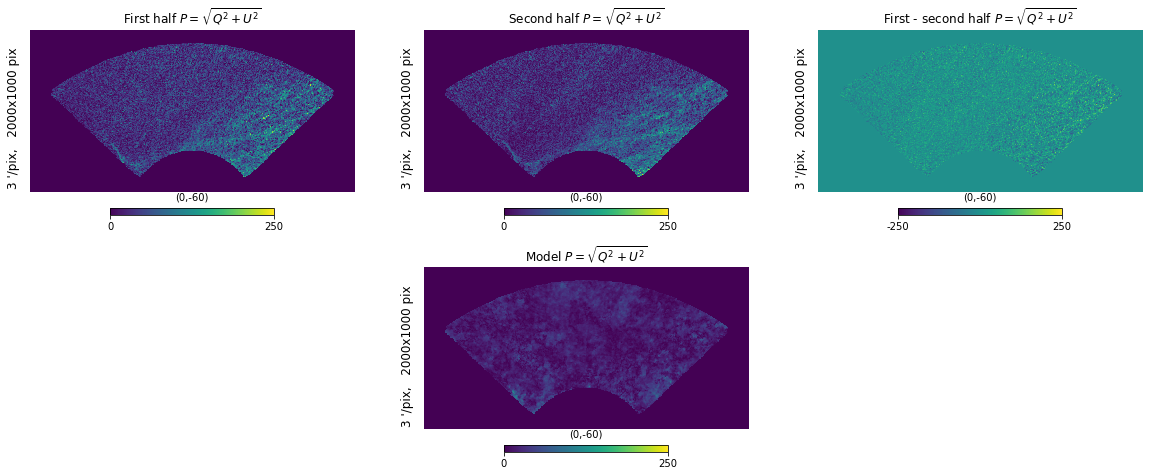

In [16]:
pl.figure(figsize=(20,8))
pl.subplot('231')
hp.gnomview(mask*np.sqrt((freq_maps_1st[1]**2+freq_maps_1st[2]**2)),rot=[0,-60],xsize=2000,ysize=1000,reso=3,hold=True,max=250,title='First half $P=\sqrt{Q^2+U^2}$')
pl.subplot('232')
hp.gnomview(mask*np.sqrt((freq_maps_2nd[1]**2+freq_maps_2nd[2]**2)),rot=[0,-60],xsize=2000,ysize=1000,reso=3,hold=True,max=250,title='Second half $P=\sqrt{Q^2+U^2}$')
pl.subplot('233')
hp.gnomview(mask*(np.sqrt((freq_maps_1st[1]**2+freq_maps_1st[2]**2))-np.sqrt((freq_maps_2nd[1]**2+freq_maps_2nd[2]**2))),rot=[0,-60],xsize=2000,ysize=1000,reso=3,hold=True,min=-250,max=250,title='First - second half $P=\sqrt{Q^2+U^2}$')
pl.subplot('235')
hp.gnomview(mask*np.sqrt((model_freq_maps[1]**2+model_freq_maps[2]**2)),rot=[0,-60],xsize=2000,ysize=1000,reso=3,hold=True,max=250,title='Model $P=\sqrt{Q^2+U^2}$')

# 4) Power spectra
Considering that the goal is a measurement of the CMB power spectrum it is important to appropriately characterize the impact of foregrounds on such a power spectrum measurement. Note that galactic foregrounds are not statistically isotropic, which means it is not a simple function of the angular multipole $C_\ell$ as in the case of the CMB. Nevertheless we can compute the quantity
$$\hat{C}_\ell=\frac{1}{2\ell+1} \sum_m a^*_{\ell m} a_{\ell m},$$
which is a quantity that depends on the actual observed region of the sky and measures the bias of foregrounds on a naive CMB power spectrum estimation. In HEALPix this quantity is computed from maps with the function `anafast`.

We can now compute the power spectra of the simulation and the real data. We'll also compute the spectra of the half mission maps as well as the cross-spectrum between them (one $a_{\ell m}$ of the equation above comes from the first half, the other $a_{\ell m}$ from the second half).

In [7]:
lmax=500

Cell_real=hp.anafast(mask*freq_maps,lmax=lmax)
Cell_sim =hp.anafast(mask*freq_maps,lmax=lmax)

Cell_1st=hp.anafast(mask*freq_maps_1st,lmax=lmax)
Cell_2nd=hp.anafast(mask*freq_maps_2nd,lmax=lmax)
Cell_cross=hp.anafast(mask*freq_maps_1st,map2=mask*freq_maps_2nd,lmax=lmax)

In [8]:
fsky=(np.mean(mask**2))
print(fsky)

0.006744503189863149


And now some plots. I'm plotting the spectra, $C_\ell$, a prefactor $\ell(\ell+1)/2\pi$, which had/has the purpose to display CMB spectra as relatively flat curves.

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in power


(2, 2000)

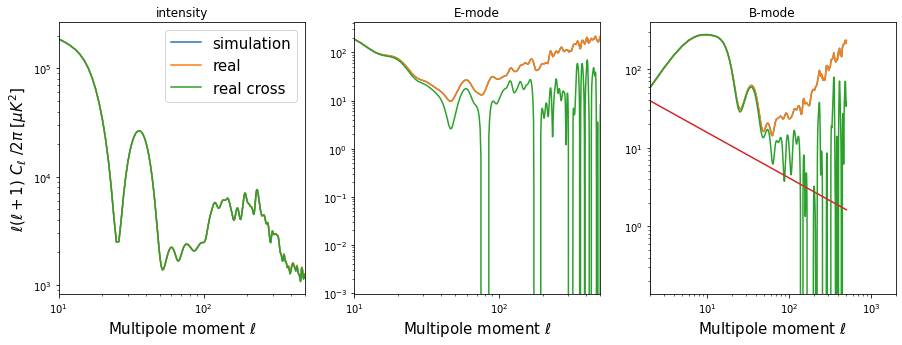

In [9]:
ell=np.arange(lmax+1)

pl.figure(figsize=(15,5))
ax=pl.subplot('131')

ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_sim[0]/fsky,label='simulation')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_real[0]/fsky,label='real')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_cross[0]/fsky,label='real cross')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('intensity')
ax.set_xlabel('Multipole moment $\ell$',fontsize=15)
ax.set_ylabel('$\ell(\ell+1)$ $C_\ell$ $/2\pi$ $[\mu K^2]$',fontsize=15)
ax.set_xlim(10,500)
pl.legend(fontsize=15)

ax=pl.subplot('132')

ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_sim[1]/fsky,label='simulation')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_real[1]/fsky,label='real')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_cross[1]/fsky,label='real cross')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('E-mode')
ax.set_xlabel('Multipole moment $\ell$',fontsize=15)
ax.set_xlim(10,500)

ax=pl.subplot('133')

ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_sim[2]/fsky,label='simulation')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_real[2]/fsky,label='real')
ax.plot(ell,ell*(ell+1)/2/np.pi*Cell_cross[2]/fsky,label='real cross')
pl.loglog(ell,4.7*(ell/80)**(-0.58))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('B-mode')
ax.set_xlabel('Multipole moment $\ell$',fontsize=15)
ax.set_xlim(2,2000)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


(10, 500)

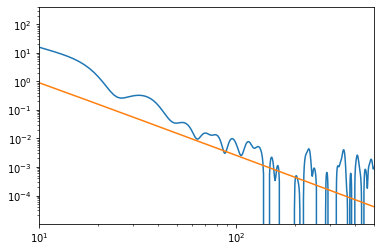

In [17]:
# pl.plot(ell,Cell_sim[2]/fsky,label='simulation')
# pl.plot(ell,Cell_real[2]/fsky,label='real')
pl.plot(ell,Cell_cross[2]/fsky,label='real cross')
pl.loglog(ell,4.7*(ell/80)**(-0.58)/(ell*(ell+1)/2/np.pi))
pl.xlim(10,500)

In [5]:
smallmask=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_largefield_cel_n0512.fits')


/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


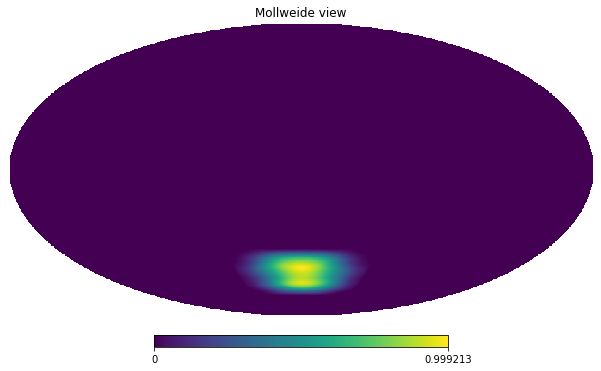

In [6]:
hp.mollview(np.nan_to_num(smallmask))

In [10]:
bigmask=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_largefield_cel_n0512.fits')
bigmask=np.nan_to_num(hp.ud_grade(bigmask,nside))
bigmask[bigmask<0]=0

mask=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_smallfield_cel_n0512.fits')
mask=np.nan_to_num(hp.ud_grade(mask,nside))
mask[mask<0]=0

lmax=2*nside

rot = hp.Rotator(coord=['G','C'])


def make_avg_sim_cl(l0=70,b0=24,p0=0.26,alphaM=-2.5,fM=0.9,N=7,Nsims=30):
    cl_big=np.zeros(lmax+1)
    cl_small=np.zeros(lmax+1)
    
    Adust_big=[]
    Adust_small=[]
    
    for i in range(Nsims):
        dust_sim=make_dustsim(l0=l0*d2r,\
                      b0=b0*d2r,\
                      p0=p0,\
                      alphaM=alphaM,\
                      fM=fM,\
                      N=N)
        dust_sim=rot.rotate_map_pixel(dust_sim)
        cl_big+=hp.anafast(bigmask*dust_sim,lmax=lmax)[2]
        cl_small+=hp.anafast(smallmask*dust_sim,lmax=lmax)[2]
        cl_big*=1./Nsims    
        cl_small*=1./Nsims
        Adust_big.append(cl_big[80])
        Adust_small.append(cl_small[80])
    
    return np.array(Adust_big),np.array(Adust_small)

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [ ]:
fsky=np.mean(mask**2)
ell=np.arange(2*nside+1)

Cell_cross=hp.anafast(mask*freq_maps_1st,map2=mask*freq_maps_2nd,lmax=lmax)

pl.plot(ell,(ell*(ell+1))/2/np.pi*make_sim_cl(p0=.03,alphaM=-3.5)/fsky,c='grey',alpha=.6)
pl.plot(ell,(ell*(ell+1))/2/np.pi*make_sim_cl(p0=.03,alphaM=-3.5)/fsky,c='grey',alpha=.6)
pl.plot(ell,(ell*(ell+1))/2/np.pi*make_sim_cl(p0=.03,alphaM=-3.5)/fsky,c='grey',alpha=.6)
pl.plot(ell,(ell*(ell+1))/2/np.pi*make_sim_cl(p0=.03,alphaM=-3.5)/fsky,c='grey',alpha=.6)
pl.plot(ell,(ell*(ell+1))/2/np.pi*make_sim_cl(p0=.03,alphaM=-3.5)/fsky,c='grey',alpha=.6)
pl.plot(ell,(ell*(ell+1))/2/np.pi*Cell_cross[2]/fsky,c='C1')

pl.loglog(ell,4.7*(ell/80)**(-0.58))
pl.xlim(10,500)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


In [45]:
mask=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/spt_2018_mask.fits')
mask=np.nan_to_num(hp.ud_grade(mask,nside))
mask[mask<0]=0

lmax=2*nside

rot = hp.Rotator(coord=['G','C'])


def make_sim_cl(l0=70,b0=24,p0=0.26,alphaM=-2.5,fM=0.9,N=7,Nsims=30):
    cl_big=np.zeros(lmax+1)
    cl_small=np.zeros(lmax+1)
    
    Adust_big=[]
    Adust_small=[]
    
    dust_sim=make_dustsim(l0=l0*d2r,\
                      b0=b0*d2r,\
                      p0=p0,\
                      alphaM=alphaM,\
                      fM=fM,\
                      N=N)
    dust_sim=rot.rotate_map_pixel(dust_sim)
    cl_small=hp.anafast(mask*dust_sim,lmax=lmax)[2]

    return cl_small

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


Text(0, 0.5, 'rel. A_{dust} increase')

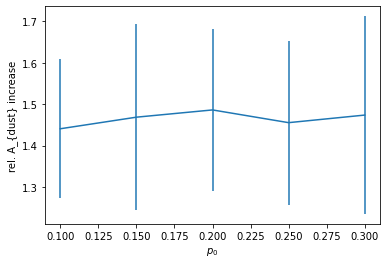

In [10]:
p0s=[0.1,0.15,0.2,0.25,0.3]
reladust=[]
for p0 in p0s:
    adustb,adusts=make_avg_sim_cl(p0=p0,Nsims=50)
    reladust.append(adustb/adusts)
    
reladust=np.array(reladust)
pl.errorbar(p0s,np.mean(reladust,axis=1),yerr=np.std(reladust,axis=1))
pl.xlabel(r'$p_0$')
pl.ylabel(r'rel. A_{dust} increase')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in arccos
  after removing the cwd from sys.path.


Text(0, 0.5, 'rel. A_{dust} increase')

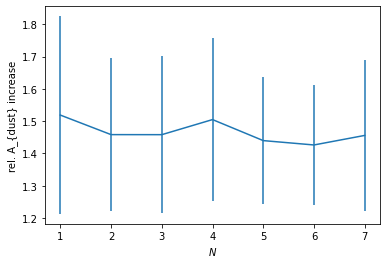

In [11]:
Ns=[1,2,3,4,5,6,7]
reladust=[]
for N in Ns:
    adustb,adusts=make_avg_sim_cl(N=N,Nsims=50)
    reladust.append(adustb/adusts)
    
reladust=np.array(reladust)
pl.errorbar(Ns,np.mean(reladust,axis=1),yerr=np.std(reladust,axis=1))
pl.xlabel(r'$N$')
pl.ylabel(r'rel. A_{dust} increase')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


Text(0, 0.5, 'rel. A_{dust} increase')

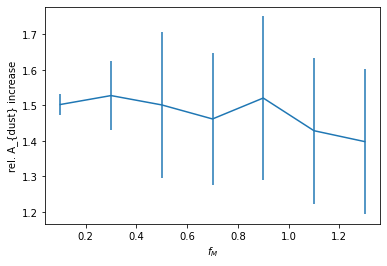

In [12]:
fMs=[0.1,0.3,0.5,0.7,0.9,1.1,1.3]
reladust=[]
for fM in fMs:
    adustb,adusts=make_avg_sim_cl(fM=fM,Nsims=50)
    reladust.append(adustb/adusts)
    
reladust=np.array(reladust)
pl.errorbar(fMs,np.mean(reladust,axis=1),yerr=np.std(reladust,axis=1))
pl.xlabel(r'$f_M$')
pl.ylabel(r'rel. A_{dust} increase')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


Text(0, 0.5, 'rel. A_{dust} increase')

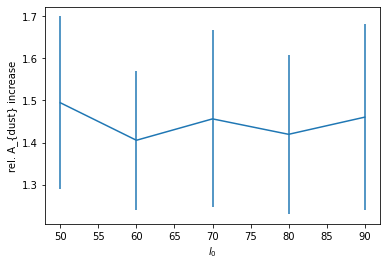

In [13]:
l0s=[50,60,70,80,90]
reladust=[]
for l0 in l0s:
    adustb,adusts=make_avg_sim_cl(l0=l0,Nsims=50)
    reladust.append(adustb/adusts)
    
reladust=np.array(reladust)
pl.errorbar(l0s,np.mean(reladust,axis=1),yerr=np.std(reladust,axis=1))
pl.xlabel(r'$l_0$')
pl.ylabel(r'rel. A_{dust} increase')

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':


Text(0, 0.5, 'rel. A_{dust} increase')

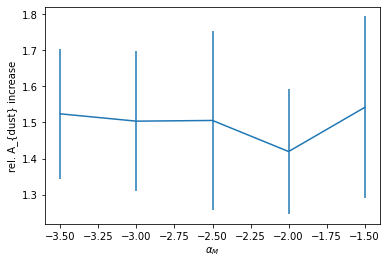

In [15]:
als=[-1.5,-2.,-2.5,-3.,-3.5]
reladust=[]
for al in als:
    adustb,adusts=make_avg_sim_cl(alphaM=al,Nsims=50)
    reladust.append(adustb/adusts)
    
reladust=np.array(reladust)
pl.errorbar(als,np.mean(reladust,axis=1),yerr=np.std(reladust,axis=1))
pl.xlabel(r'$\alpha_M$')
pl.ylabel(r'rel. A_{dust} increase')

You can see that the power spectra match very well when we consider the cross spectra of the real data. This is because the noise, which is primarily responsible for the excess at higher multipoles in the orange line, does not correlate between the two halves. Hence, we are sure that the green line represents the signal. It has to be checked if the difference in the intensity spectrum is due to the CMB in the real data or not.

In [22]:
!mv bk14_mask_cel_n0512.fits /home/groups/clkuo/planck_maps_for_george/masks/bk14_mask_cel_n0512.fits

mv: cannot create regular file ‘/home/groups/clkuo/planck_maps_for_george/masks/bk14_mask_cel_n0512.fits’: Permission denied


In [32]:
nside=256

mask_sm=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_smallfield_cel_n0512.fits')
mask_sm=np.nan_to_num(hp.ud_grade(mask_sm,nside))
mask_sm[mask_sm<0]=0
fsky_sm=np.mean(mask_sm**2)

mask_lg=hp.read_map('/home/groups/clkuo/planck_maps_for_george/masks/bk18_mask_largefield_cel_n0512.fits')
mask_lg=np.nan_to_num(hp.ud_grade(mask_lg,nside))
mask_lg[mask_lg<0]=0
fsky_lg=np.mean(mask_lg**2)

/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/users/dobeck/.local/lib/python3.6/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


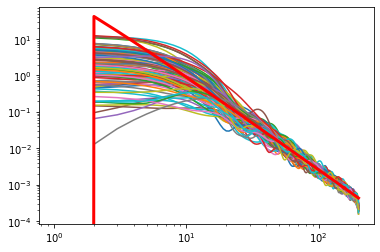

In [37]:
from scipy.optimize import minimize

def f(A, ell,Cell,fsky):
    # function to minimize
    # note CellBK is not Cell_BK here
    CellBK = 2*np.pi/(ell*(ell+1))*A*(ell/80)**(-0.58)
    sigma_Cell = np.sqrt(2/((2*ell+1)*fsky))*CellBK
    return np.sum((CellBK-Cell)**2/sigma_Cell**2)
lmax=200
ell=np.arange(lmax+1)
Cell_BK = 2*np.pi/(ell*(ell+1))*4.7*(ell/80)**(-0.58)
Cell_BK[:2] = 0
Cell_TTTE = np.zeros(ell.shape)
absdiff=[]
A_sm=[]
A_lg=[]
for i in range(100):
    maps = hp.synfast((Cell_TTTE,Cell_TTTE,Cell_BK,Cell_BK),nside,lmax=lmax,verbose=False,new=True) #TT,TE,EE,BB
    Cell_sm = hp.anafast(mask_sm*maps,lmax=lmax)[2]/fsky_sm
    Cell_lg = hp.anafast(mask_lg*maps,lmax=lmax)[2]/fsky_lg
    pl.plot(Cell_sm)
    result_sm = minimize(f,[4.7], args=(ell[50:], Cell_sm[50:], fsky_sm)).x
    result_lg = minimize(f,[4.7], args=(ell[50:], Cell_lg[50:], fsky_lg)).x
    A_sm.append(result_sm[0])
    A_lg.append(result_lg[0])
    absdiff.append(np.abs(result_sm[0]-result_lg[0]))
absdiffmean = np.mean(np.array(absdiff))
absdiffstd = np.std(np.array(absdiff))
A_sm_mean = np.mean(A_sm)
A_sm_std = np.std(A_sm)
A_lg_mean = np.mean(A_lg)
A_lg_std = np.std(A_lg)
pl.loglog(Cell_BK,c='r',lw=3)

(array([ 4.,  4., 16., 17., 17., 17.,  9., 10.,  4.,  2.]),
 array([4.23608041, 4.36135471, 4.48662901, 4.61190331, 4.73717761,
        4.86245191, 4.9877262 , 5.1130005 , 5.2382748 , 5.3635491 ,
        5.4888234 ]),
 <a list of 1 Patch objects>)

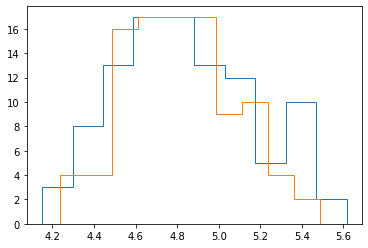

In [34]:
pl.hist(A_sm,histtype='step')
pl.hist(A_lg,histtype='step')

In [35]:
np.mean(A_sm)

4.842623983268926